We are using Oxford 102 Flower Dataset for this project. You can download the dataset from [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

In [1]:
# ================================
# Oxford 102 Flowers + CLIP Text Conditioning Dataset
# ================================


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from pathlib import Path

# Compatibility shim for older openai-clip
try:
    import pkg_resources as _pkg_resources  # type: ignore
    import packaging as _packaging  # type: ignore
    if not hasattr(_pkg_resources, "packaging"):
        _pkg_resources.packaging = _packaging
except Exception:
    
    pass

import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Download Oxford 102 Flowers
DATA_DIR = Path(".dataset/flowers102")
DATA_DIR.mkdir(parents=True, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

train_ds = datasets.Flowers102(root=DATA_DIR, split="train", download=True, transform=transform)
val_ds   = datasets.Flowers102(root=DATA_DIR, split="val", download=True, transform=transform)
test_ds  = datasets.Flowers102(root=DATA_DIR, split="test", download=True, transform=transform)

# --- Oxford-102 official class name mapping
cat_to_name = {
    "1": "pink primrose", "2": "hard-leaved pocket orchid", "3": "canterbury bells", "4": "sweet pea",
    "5": "english marigold", "6": "tiger lily", "7": "moon orchid", "8": "bird of paradise",
    "9": "monkshood", "10": "globe thistle", "11": "snapdragon", "12": "colt's foot",
    "13": "king protea", "14": "spear thistle", "15": "yellow iris", "16": "globe-flower",
    "17": "purple coneflower", "18": "peruvian lily", "19": "balloon flower", "20": "giant white arum lily",
    "21": "fire lily", "22": "pincushion flower", "23": "fritillary", "24": "red ginger",
    "25": "grape hyacinth", "26": "corn poppy", "27": "prince of wales feathers", "28": "stemless gentian",
    "29": "artichoke", "30": "sweet william", "31": "carnation", "32": "garden phlox",
    "33": "love in the mist", "34": "mexican aster", "35": "alpine sea holly", "36": "ruby-lipped cattleya",
    "37": "cape flower", "38": "great masterwort", "39": "siam tulip", "40": "lenten rose",
    "41": "barbeton daisy", "42": "daffodil", "43": "sword lily", "44": "poinsettia",
    "45": "bolero deep blue", "46": "wallflower", "47": "marigold", "48": "buttercup",
    "49": "oxeye daisy", "50": "common dandelion", "51": "petunia", "52": "wild pansy",
    "53": "primula", "54": "sunflower", "55": "pelargonium", "56": "bishop of llandaff",
    "57": "gaura", "58": "geranium", "59": "orange dahlia", "60": "pink-yellow dahlia",
    "61": "cautleya spicata", "62": "japanese anemone", "63": "black-eyed susan", "64": "silverbush",
    "65": "californian poppy", "66": "osteospermum", "67": "spring crocus", "68": "bearded iris",
    "69": "windflower", "70": "tree poppy", "71": "gazania", "72": "azalea",
    "73": "water lily", "74": "rose", "75": "thorn apple", "76": "morning glory",
    "77": "passion flower", "78": "lotus lotus", "79": "toad lily", "80": "anthurium",
    "81": "frangipani", "82": "clematis", "83": "hibiscus", "84": "columbine",
    "85": "desert-rose", "86": "tree mallow", "87": "magnolia", "88": "cyclamen",
    "89": "watercress", "90": "canna lily", "91": "hippeastrum", "92": "bee balm",
    "93": "ball moss", "94": "foxglove", "95": "bougainvillea", "96": "camellia",
    "97": "mallow", "98": "mexican petunia", "99": "bromelia", "100": "blanket flower",
    "101": "trumpet creeper", "102": "blackberry lily"
}
class_names = [cat_to_name[str(i)] for i in range(1, 103)] 

print("Total classes:", len(class_names))
print("Example flower classes:", class_names[:10])

# --- Load CLIP (ViT-B/32)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def prompt_to_embedding(prompt: str) -> torch.Tensor:
    """
    Encode a free-text prompt into a CLIP text embedding.
    Returns a normalised vector [D].
    """
    text_tokens = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        emb = clip_model.encode_text(text_tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.squeeze(0).cpu()

# --- Wrap Flowers102 with text embeddings
class FlowersWithText(Dataset):
    def __init__(self, base_ds, class_names, clip_model):
        self.base = base_ds
        self.class_names = class_names
        self.clip_model = clip_model

        # Precompute embeddings for all class names
        print("Precomputing text embeddings for all classes...")
        self.class_embeds = {}
        for cname in class_names:
            self.class_embeds[cname] = prompt_to_embedding(cname)

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        cname = self.class_names[label]
        text_emb = self.class_embeds[cname]
        return {
            "image": img,            # Tensor [3,H,W]
            "label": label,          # int
            "class_name": cname,     # str
            "text_embed": text_emb   # Tensor [D]
        }

# Instantiate wrapped datasets
train_ds_wrapped = FlowersWithText(train_ds, class_names, clip_model)
val_ds_wrapped   = FlowersWithText(val_ds, class_names, clip_model)

# --- Quick DataLoader test
loader = DataLoader(train_ds_wrapped, batch_size=4, shuffle=True)
batch = next(iter(loader))

print("Image batch:", batch["image"].shape)        # [B,3,H,W]
print("Text embedding batch:", batch["text_embed"].shape)  # [B,D]
print("Class names:", batch["class_name"])

C:\Users\utkaa\AppData\Local\Temp\ipykernel_18608\1027410029.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources as _pkg_resources  # type: ignore


Total classes: 102
Example flower classes: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle']
Precomputing text embeddings for all classes...
Precomputing text embeddings for all classes...
Image batch: torch.Size([4, 3, 128, 128])
Text embedding batch: torch.Size([4, 512])
Class names: ['cape flower', 'columbine', 'trumpet creeper', 'azalea']


train: found 10 'yellow iris' images.


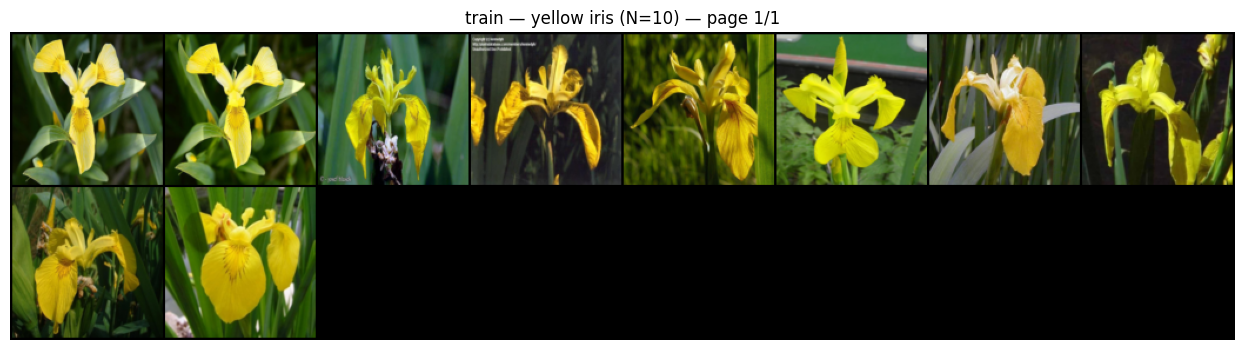

val: found 10 'yellow iris' images.


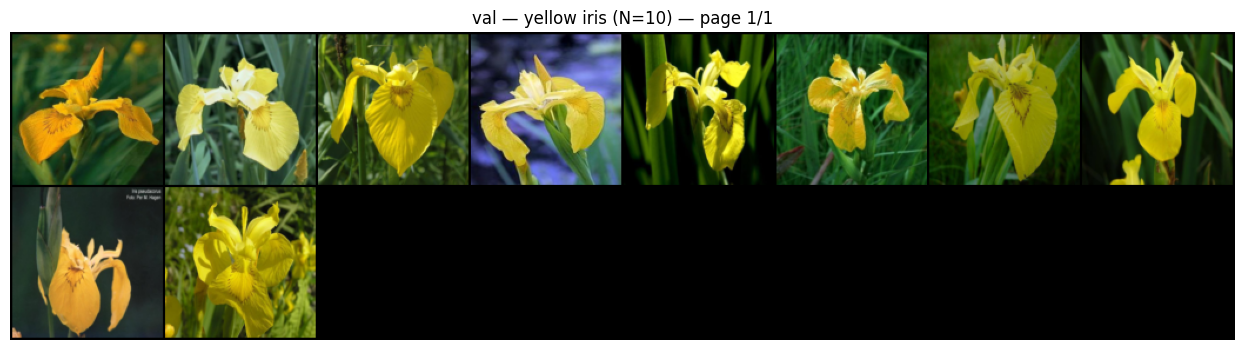

test: found 29 'yellow iris' images.


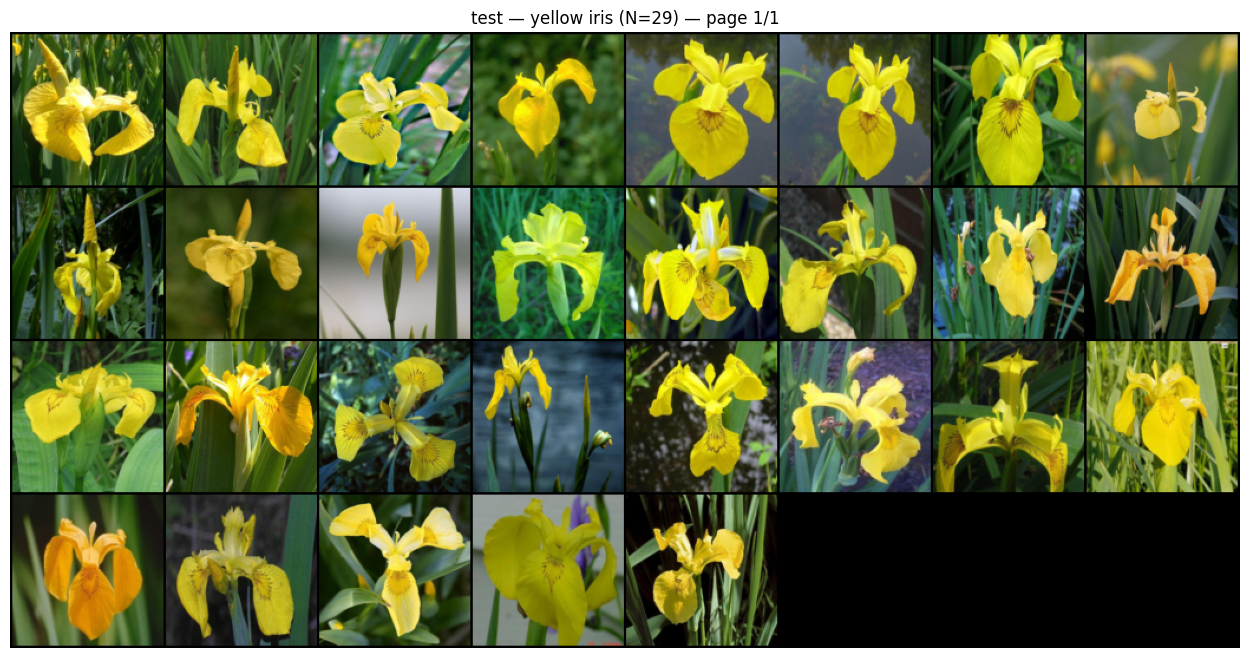

In [8]:
# Display all images of the class "yellow iris" from train/val/test

# Use existing globals when available; import only if missing
try:
    make_grid
except NameError:
    from torchvision.utils import make_grid  # fallback

try:
    plt
except NameError:
    import matplotlib.pyplot as plt  # fallback

target_name = "yellow iris"

def _indices_for_class(ds, cname):
    labels = getattr(ds, "_labels", None)
    if labels is not None:
        return [i for i, y in enumerate(labels) if class_names[y] == cname]
    # fallback: slower path
    idxs = []
    for i in range(len(ds)):
        _, y = ds[i]
        if class_names[y] == cname:
            idxs.append(i)
    return idxs

splits = [("train", train_ds), ("val", val_ds), ("test", test_ds)]

for split_name, ds in splits:
    idxs = _indices_for_class(ds, target_name)
    if not idxs:
        print(f"No '{target_name}' images found in {split_name}.")
        continue

    print(f"{split_name}: found {len(idxs)} '{target_name}' images.")
    # Load images
    imgs = [ds[i][0] for i in idxs]  # tensors [3, H, W] in 0..1

    # Show in chunks to avoid huge single figures
    chunk_size = 64
    nrow = 8
    for start in range(0, len(imgs), chunk_size):
        chunk = imgs[start:start + chunk_size]
        grid = make_grid(chunk, nrow=nrow, padding=2)
        rows = (len(chunk) + nrow - 1) // nrow
        plt.figure(figsize=(2 * nrow, 2 * rows))
        plt.axis("off")
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        page = start // chunk_size + 1
        pages = (len(imgs) + chunk_size - 1) // chunk_size
        plt.title(f"{split_name} — {target_name} (N={len(imgs)}) — page {page}/{pages}")
        plt.show()

In [ ]:
# ================================
# Text → ViT Embedding → Projection (to 128-dim for NCA)
# ================================
import torch
import torch.nn as nn

# Projection head: map CLIP’s 512-dim text embeddings to 128-dim
COND_DIM = 128

class TextConditioningHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)  # two layers for a bit more capacity
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # normalise to unit length for stability
        return x / (x.norm(dim=-1, keepdim=True) + 1e-8)

# Instantiate
cond_head = TextConditioningHead(in_dim=512, out_dim=COND_DIM).to(device)

def prompt_to_cond(prompt: str) -> torch.Tensor:
    """
    Encode free-text prompt into a 128-dim conditioning vector for NCA.
    """
    # Step 1: CLIP text encoding (512-dim)
    text_tokens = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        emb_512 = clip_model.encode_text(text_tokens)
        emb_512 = emb_512 / emb_512.norm(dim=-1, keepdim=True)

    # Step 2: Project to 128-dim
    with torch.no_grad():
        emb_128 = cond_head(emb_512)

    return emb_128.squeeze(0).cpu()

# --- Demo
demo_prompts = ["sunflower", "pink sunflower", "yellow daffodil", "orchid with white petals"]
for p in demo_prompts:
    vec = prompt_to_cond(p)
    print(f"Prompt: {p:25s} -> Conditioning vector shape: {tuple(vec.shape)} | norm={vec.norm().item():.2f}")


Prompt: sunflower                 -> Conditioning vector shape: (128,) | norm=1.00
Prompt: pink sunflower            -> Conditioning vector shape: (128,) | norm=1.00
Prompt: yellow daffodil           -> Conditioning vector shape: (128,) | norm=1.00
Prompt: orchid with white petals  -> Conditioning vector shape: (128,) | norm=1.00


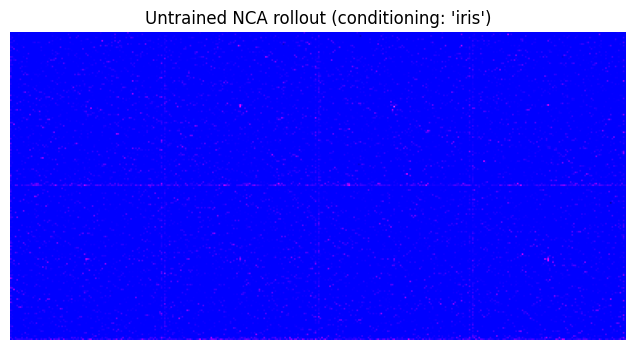

In [3]:
# ================================
# Conditioning-aware NCA (FiLM) + quick rollout demo
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# NCA config
STATE_CH = 32          # 3 RGB + 29 hidden
PERCEPT_CH = 64        # features inside the NCA
UPDATE_RATE = 0.5
IMG_SIZE = 96          # keep small for speed in demo
STEPS = 32

class FiLMNCA(nn.Module):
    """
    A tiny Neural Cellular Automata with FiLM modulation from a global conditioning vector.
    - state: [B, C, H, W] with first 3 channels reserved for RGB (clamped 0..1)
    - cond:  [B, COND_DIM] (128 from your projection head)
    """
    def __init__(self, state_ch=STATE_CH, cond_dim=COND_DIM, percept_ch=PERCEPT_CH):
        super().__init__()
        self.state_ch = state_ch

        # Perception (look at a 3x3 neighbourhood)
        self.perc = nn.Conv2d(state_ch, percept_ch, kernel_size=3, padding=1)

        # FiLM mapping: cond -> (gamma, beta) for 'percept_ch' channels
        self.film = nn.Linear(cond_dim, 2 * percept_ch)

        # Update rule: small MLP over channels (1x1 convs)
        self.update = nn.Sequential(
            nn.Conv2d(percept_ch, percept_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(percept_ch, state_ch, kernel_size=1)
        )

    @torch.no_grad()
    def _stochastic_mask(self, x, rate=UPDATE_RATE):
        # Update a random subset of cells each step (as in standard NCA setups)
        return (torch.rand_like(x[:, :1]) <= rate).float()

    def forward(self, state, cond, steps=STEPS, update_rate=UPDATE_RATE):
        """
        state: [B,C,H,W], cond: [B,COND_DIM]
        returns: final state after 'steps'
        """
        B, C, H, W = state.shape
        # Precompute FiLM params
        gb = self.film(cond)                  # [B, 2*percept_ch]
        gamma, beta = gb.chunk(2, dim=1)      # [B,percept_ch], [B,percept_ch]
        gamma = gamma[:, :, None, None]       # [B,percept_ch,1,1]
        beta  = beta[:,  :, None, None]

        for _ in range(steps):
            y = self.perc(state)              # [B,percept_ch,H,W]
            # FiLM modulation
            y = y * (1 + gamma) + beta
            delta = self.update(y)            # [B,C,H,W]
            mask = self._stochastic_mask(state, rate=update_rate)
            state = state + delta * mask
            # Keep RGB in range
            state[:, :3].clamp_(0.0, 1.0)
        return state

# Helper: make a seed grid (tiny spark in hidden channels)
def make_seed(B, H=IMG_SIZE, W=IMG_SIZE, C=STATE_CH, device=device):
    x = torch.zeros(B, C, H, W, device=device)
    cy, cx = H // 2, W // 2
    x[:, 3:, cy-1:cy+1, cx-1:cx+1] = 1.0
    return x

# Instantiate NCA
nca = FiLMNCA(state_ch=STATE_CH, cond_dim=COND_DIM, percept_ch=PERCEPT_CH).to(device)

# --- Smoke test: untrained NCA with a real prompt embedding
with torch.no_grad():
    B = 8
    seed = make_seed(B)
    cond = torch.stack([prompt_to_cond("iris") for _ in range(B)], dim=0).to(device)
    out = nca(seed, cond, steps=STEPS, update_rate=UPDATE_RATE)  # [B,STATE_CH,H,W]
    rgb = out[:, :3].detach().cpu()

# Visualise
grid = torch.concat([
    torch.concat([rgb[i] for i in range(0,4)], dim=2),
    torch.concat([rgb[i] for i in range(4,8)], dim=2)
], dim=1)  # simple 2x4 grid, [3, 2H, 4W]

plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(grid.permute(1,2,0).numpy())
plt.title("Untrained NCA rollout (conditioning: 'iris')")
plt.show()

# Note:
# This is UNTRAINED


⚙️ Running in eager mode (torch.compile disabled).
Precomputing text embeddings for all classes (CPU)…
Precomputing text embeddings for all classes (CPU)…


C:\Users\utkaa\AppData\Local\Temp\ipykernel_18608\2426082917.py:291: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


===== Training expert for class: yellow iris =====


NCA[yellow iris]:   0%|          | 0/3200 [00:00<?, ?it/s]C:\Users\utkaa\AppData\Local\Temp\ipykernel_18608\2426082917.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):
C:\Users\utkaa\AppData\Local\Temp\ipykernel_18608\2426082917.py:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
C:\Users\utkaa\AppData\Local\Temp\ipykernel_18608\2426082917.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):
NCA[yellow iris]:   6%|▋         | 200/3200 [00:36<08:19,  6.01it/s, clip=0.8372, loss=0.4149, pix=0.2340, steps=16]C:\Users\utkaa\AppData\Local\Temp\ipykernel_18608\2426082917.py:247: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprec

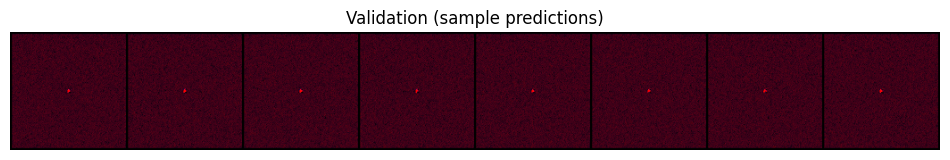

Val[yellow iris] @ 200: pixL1=0.2406 | clipLoss=0.8408 | total=1.0815
✅ Saved BEST → best_flower-yellow_iris_20250929-091346.pt


NCA[yellow iris]:  12%|█▎        | 400/3200 [01:10<08:08,  5.73it/s, clip=0.8588, loss=0.4197, pix=0.2315, steps=16]

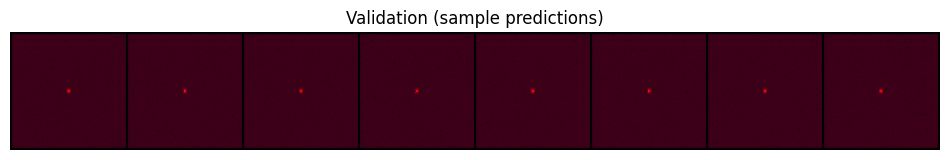

NCA[yellow iris]:  13%|█▎        | 401/3200 [01:11<12:16,  3.80it/s, clip=0.8588, loss=0.4197, pix=0.2315, steps=16]

Val[yellow iris] @ 400: pixL1=0.2391 | clipLoss=0.8618 | total=1.1010


NCA[yellow iris]:  19%|█▉        | 600/3200 [01:44<07:05,  6.11it/s, clip=0.8574, loss=0.4192, pix=0.2314, steps=16]

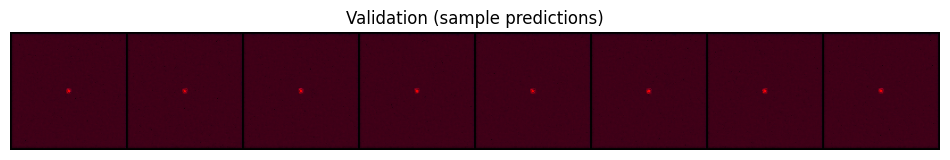

NCA[yellow iris]:  19%|█▉        | 601/3200 [01:45<11:03,  3.92it/s, clip=0.8574, loss=0.4192, pix=0.2314, steps=16]

Val[yellow iris] @ 600: pixL1=0.2392 | clipLoss=0.8584 | total=1.0976


NCA[yellow iris]:  25%|██▌       | 800/3200 [02:24<08:15,  4.85it/s, clip=0.8453, loss=0.4155, pix=0.2313, steps=24]

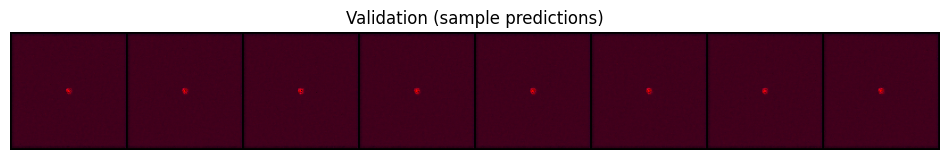

Val[yellow iris] @ 800: pixL1=0.2391 | clipLoss=0.8477 | total=1.0867


NCA[yellow iris]:  31%|███▏      | 1000/3200 [03:06<07:23,  4.96it/s, clip=0.8502, loss=0.4169, pix=0.2312, steps=24]

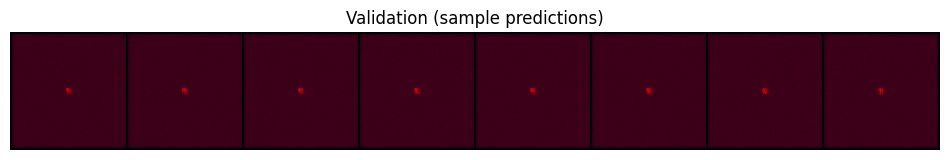

Val[yellow iris] @ 1000: pixL1=0.2387 | clipLoss=0.8481 | total=1.0868


NCA[yellow iris]:  38%|███▊      | 1200/3200 [03:47<06:50,  4.88it/s, clip=0.8392, loss=0.4135, pix=0.2311, steps=24]

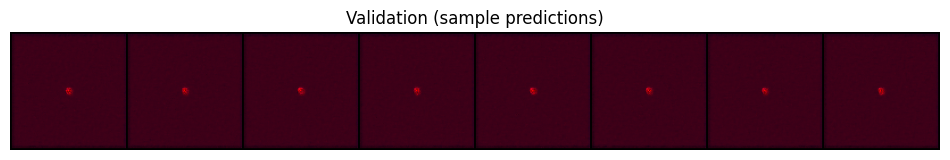

Val[yellow iris] @ 1200: pixL1=0.2386 | clipLoss=0.8403 | total=1.0789
✅ Saved BEST → best_flower-yellow_iris_20250929-091346.pt


NCA[yellow iris]:  44%|████▍     | 1400/3200 [04:34<07:23,  4.06it/s, clip=0.7705, loss=0.3490, pix=0.1684, steps=32]

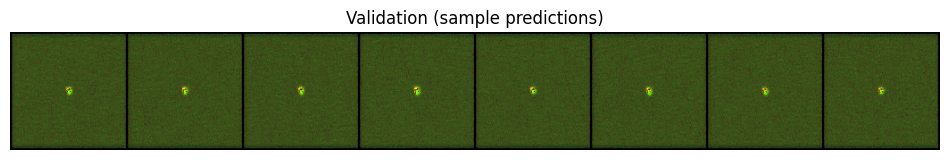

Val[yellow iris] @ 1400: pixL1=0.1717 | clipLoss=0.7754 | total=0.9471
✅ Saved BEST → best_flower-yellow_iris_20250929-091346.pt


NCA[yellow iris]:  50%|█████     | 1600/3200 [05:24<06:33,  4.07it/s, clip=0.7622, loss=0.3451, pix=0.1663, steps=32]

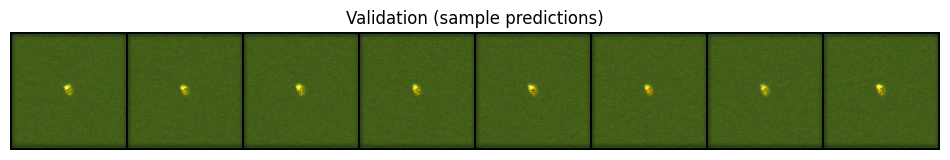

Val[yellow iris] @ 1600: pixL1=0.1702 | clipLoss=0.7627 | total=0.9329
✅ Saved BEST → best_flower-yellow_iris_20250929-091346.pt


NCA[yellow iris]:  56%|█████▋    | 1800/3200 [06:14<05:46,  4.04it/s, clip=0.7471, loss=0.3392, pix=0.1644, steps=32]

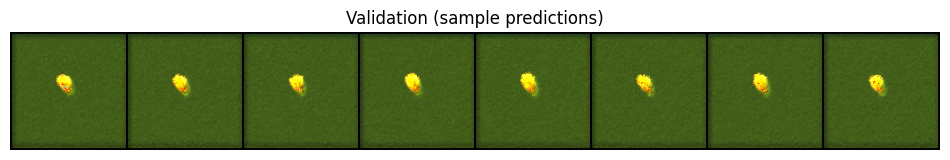

Val[yellow iris] @ 1800: pixL1=0.1692 | clipLoss=0.7539 | total=0.9231
✅ Saved BEST → best_flower-yellow_iris_20250929-091346.pt


NCA[yellow iris]:  62%|██████▎   | 2000/3200 [07:08<05:49,  3.43it/s, clip=0.7743, loss=0.3443, pix=0.1601, steps=40]

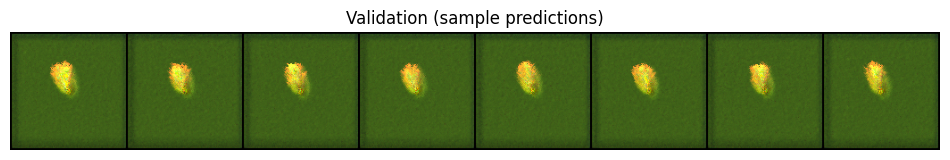

Val[yellow iris] @ 2000: pixL1=0.1644 | clipLoss=0.7739 | total=0.9383


NCA[yellow iris]:  69%|██████▉   | 2200/3200 [08:06<04:54,  3.40it/s, clip=0.7824, loss=0.3454, pix=0.1581, steps=40]

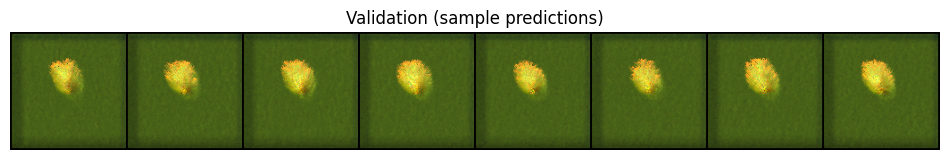

Val[yellow iris] @ 2200: pixL1=0.1617 | clipLoss=0.7754 | total=0.9371


NCA[yellow iris]:  75%|███████▌  | 2400/3200 [09:04<03:50,  3.47it/s, clip=0.7806, loss=0.3431, pix=0.1556, steps=40]

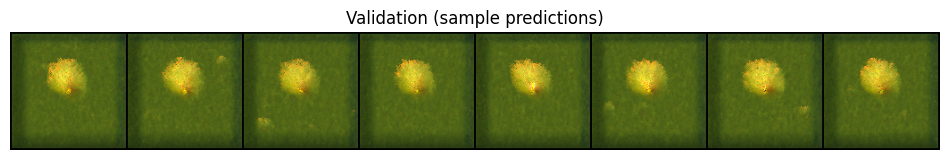

Val[yellow iris] @ 2400: pixL1=0.1590 | clipLoss=0.7788 | total=0.9378


NCA[yellow iris]:  81%|████████▏ | 2600/3200 [10:05<03:19,  3.01it/s, clip=0.7775, loss=0.3408, pix=0.1536, steps=48]

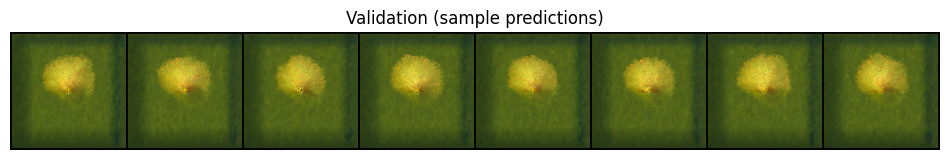

Val[yellow iris] @ 2600: pixL1=0.1535 | clipLoss=0.7700 | total=0.9235


NCA[yellow iris]:  88%|████████▊ | 2800/3200 [11:12<02:12,  3.03it/s, clip=0.7832, loss=0.3417, pix=0.1524, steps=48]

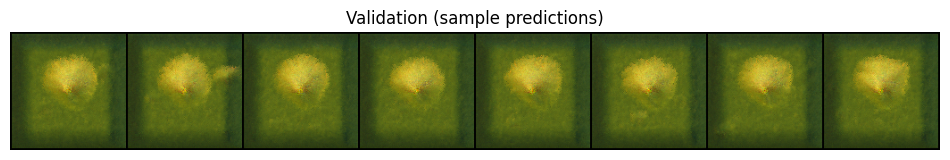

Val[yellow iris] @ 2800: pixL1=0.1523 | clipLoss=0.7764 | total=0.9286


NCA[yellow iris]:  94%|█████████▍| 3000/3200 [12:19<01:06,  2.99it/s, clip=0.7793, loss=0.3404, pix=0.1522, steps=48]

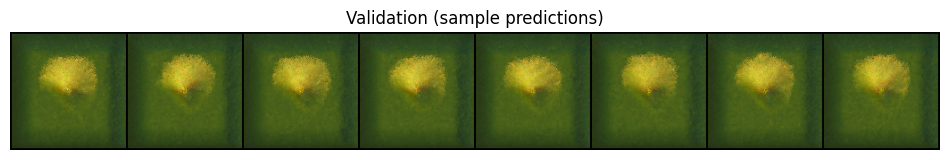

Val[yellow iris] @ 3000: pixL1=0.1523 | clipLoss=0.7803 | total=0.9326


NCA[yellow iris]: 100%|██████████| 3200/3200 [13:26<00:00,  3.04it/s, clip=0.7842, loss=0.3417, pix=0.1521, steps=48]

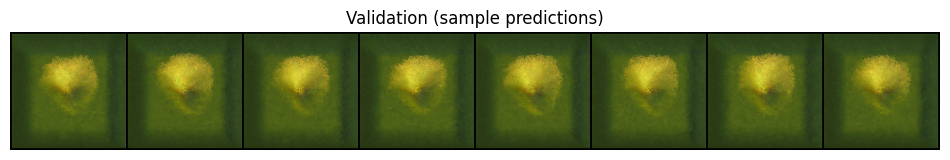

NCA[yellow iris]: 100%|██████████| 3200/3200 [13:27<00:00,  3.96it/s, clip=0.7842, loss=0.3417, pix=0.1521, steps=48]


Val[yellow iris] @ 3200: pixL1=0.1512 | clipLoss=0.7837 | total=0.9349
Done: yellow iris. Latest=latest_flower-yellow_iris_20250929-091346.pt | Best=best_flower-yellow_iris_20250929-091346.pt | Final=final_flower-yellow_iris_20250929-091346.pt
===== Training expert for class: giant white arum lily =====


NCA[giant white arum lily]:   6%|▋         | 200/3200 [00:32<08:17,  6.04it/s, clip=0.8279, loss=0.4405, pix=0.2745, steps=16]

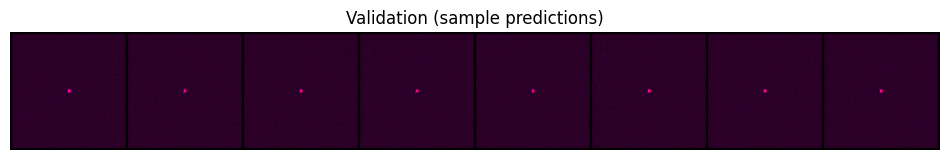

NCA[giant white arum lily]:   6%|▋         | 201/3200 [00:33<13:07,  3.81it/s, clip=0.8279, loss=0.4405, pix=0.2745, steps=16]

Val[giant white arum lily] @ 200: pixL1=0.2717 | clipLoss=0.8247 | total=1.0964
✅ Saved BEST → best_flower-giant_white_arum_lily_20250929-092714.pt


NCA[giant white arum lily]:  12%|█▎        | 400/3200 [01:06<07:38,  6.11it/s, clip=0.8237, loss=0.4389, pix=0.2741, steps=16]

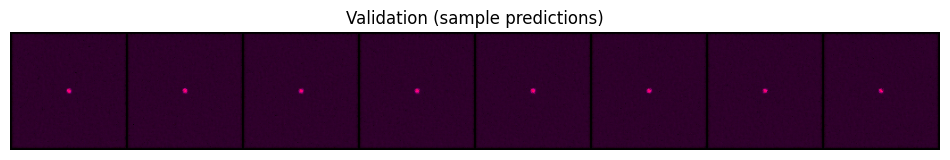

NCA[giant white arum lily]:  13%|█▎        | 401/3200 [01:06<11:47,  3.95it/s, clip=0.8237, loss=0.4389, pix=0.2741, steps=16]

Val[giant white arum lily] @ 400: pixL1=0.2708 | clipLoss=0.8262 | total=1.0970


NCA[giant white arum lily]:  19%|█▉        | 600/3200 [01:39<07:04,  6.12it/s, clip=0.7809, loss=0.3981, pix=0.2340, steps=16]

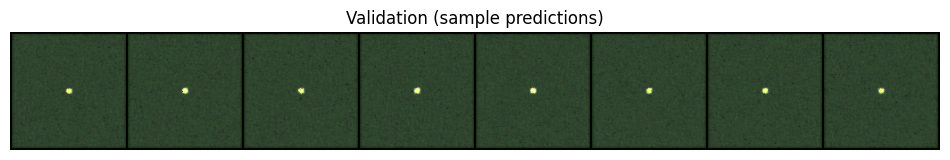

NCA[giant white arum lily]:  19%|█▉        | 601/3200 [01:39<11:46,  3.68it/s, clip=0.7809, loss=0.3981, pix=0.2340, steps=16]

Val[giant white arum lily] @ 600: pixL1=0.2275 | clipLoss=0.7793 | total=1.0068
✅ Saved BEST → best_flower-giant_white_arum_lily_20250929-092714.pt


NCA[giant white arum lily]:  25%|██▌       | 800/3200 [02:19<08:22,  4.78it/s, clip=0.7794, loss=0.3971, pix=0.2333, steps=24]

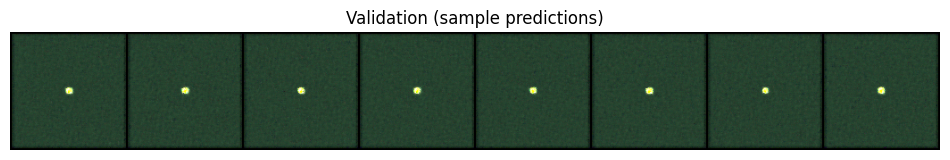

Val[giant white arum lily] @ 800: pixL1=0.2293 | clipLoss=0.7759 | total=1.0052
✅ Saved BEST → best_flower-giant_white_arum_lily_20250929-092714.pt


NCA[giant white arum lily]:  31%|███▏      | 1000/3200 [03:00<07:22,  4.97it/s, clip=0.7744, loss=0.3952, pix=0.2326, steps=24]

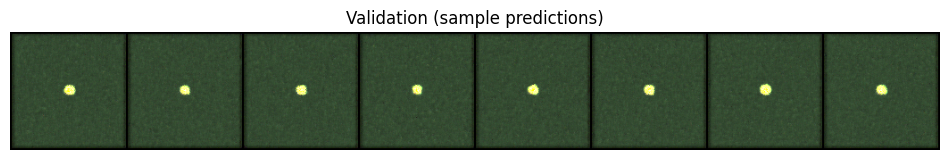

NCA[giant white arum lily]:  31%|███▏      | 1001/3200 [03:00<11:39,  3.14it/s, clip=0.7744, loss=0.3952, pix=0.2326, steps=24]

Val[giant white arum lily] @ 1000: pixL1=0.2260 | clipLoss=0.7803 | total=1.0063


NCA[giant white arum lily]:  38%|███▊      | 1200/3200 [03:41<06:47,  4.91it/s, clip=0.7868, loss=0.4076, pix=0.2451, steps=24]

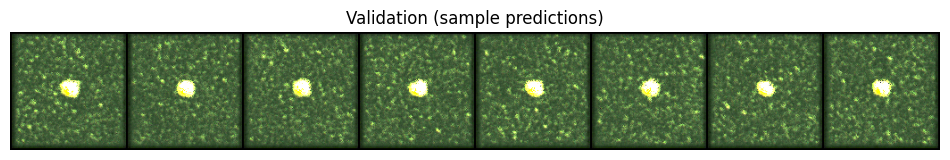

Val[giant white arum lily] @ 1200: pixL1=0.2407 | clipLoss=0.7852 | total=1.0259


NCA[giant white arum lily]:  44%|████▍     | 1400/3200 [04:26<07:20,  4.08it/s, clip=nan, loss=nan, pix=nan, steps=32]         

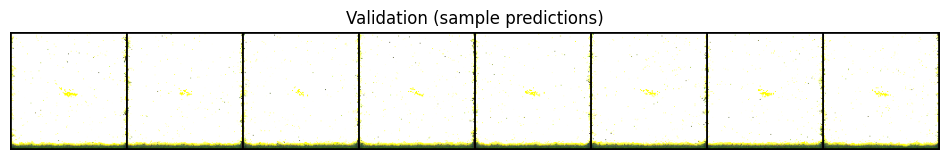

Val[giant white arum lily] @ 1400: pixL1=0.6470 | clipLoss=0.7759 | total=1.4228


NCA[giant white arum lily]:  50%|█████     | 1600/3200 [05:15<06:28,  4.12it/s, clip=nan, loss=nan, pix=nan, steps=32]

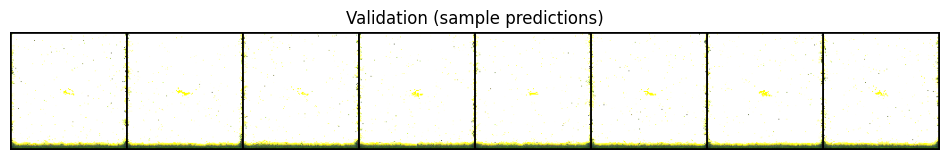

Val[giant white arum lily] @ 1600: pixL1=0.6467 | clipLoss=0.7773 | total=1.4241


NCA[giant white arum lily]:  56%|█████▋    | 1800/3200 [06:05<05:44,  4.06it/s, clip=nan, loss=nan, pix=nan, steps=32]

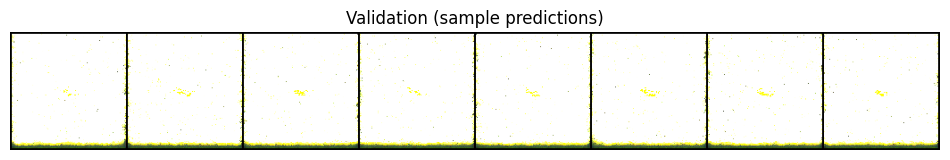

Val[giant white arum lily] @ 1800: pixL1=0.6470 | clipLoss=0.7754 | total=1.4224


NCA[giant white arum lily]:  62%|██████▎   | 2000/3200 [06:57<05:42,  3.50it/s, clip=nan, loss=nan, pix=nan, steps=40]

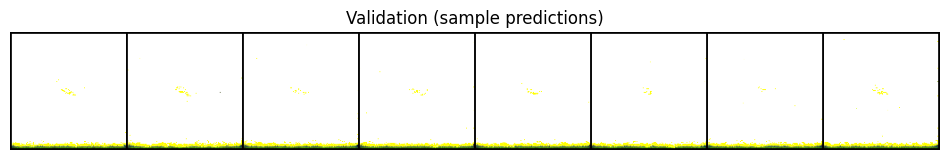

Val[giant white arum lily] @ 2000: pixL1=0.6586 | clipLoss=0.7759 | total=1.4345


NCA[giant white arum lily]:  69%|██████▉   | 2200/3200 [07:54<04:43,  3.53it/s, clip=nan, loss=nan, pix=nan, steps=40]

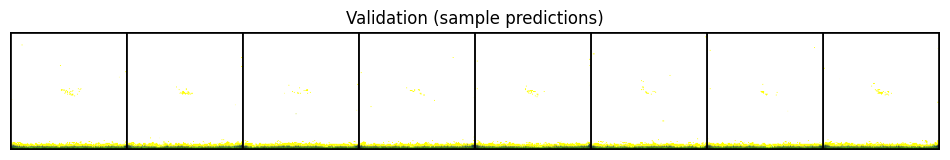

Val[giant white arum lily] @ 2200: pixL1=0.6585 | clipLoss=0.7808 | total=1.4392


NCA[giant white arum lily]:  75%|███████▌  | 2400/3200 [08:52<03:46,  3.54it/s, clip=nan, loss=nan, pix=nan, steps=40]

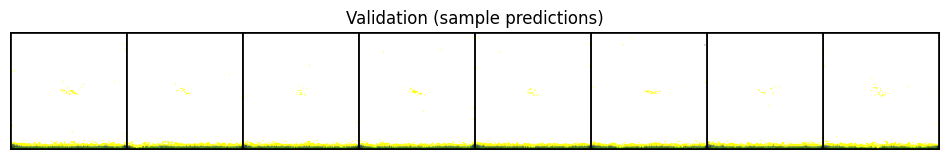

Val[giant white arum lily] @ 2400: pixL1=0.6583 | clipLoss=0.7822 | total=1.4405


NCA[giant white arum lily]:  81%|████████▏ | 2600/3200 [09:51<03:15,  3.06it/s, clip=nan, loss=nan, pix=nan, steps=48]

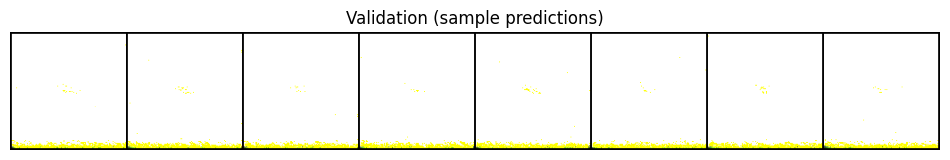

Val[giant white arum lily] @ 2600: pixL1=0.6653 | clipLoss=0.7837 | total=1.4490


NCA[giant white arum lily]:  88%|████████▊ | 2800/3200 [10:57<02:11,  3.04it/s, clip=nan, loss=nan, pix=nan, steps=48]

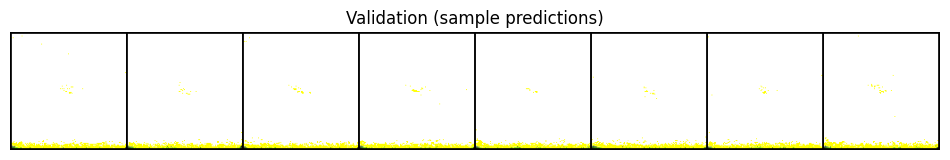

Val[giant white arum lily] @ 2800: pixL1=0.6652 | clipLoss=0.7793 | total=1.4445


NCA[giant white arum lily]:  94%|█████████▍| 3000/3200 [12:03<01:05,  3.05it/s, clip=nan, loss=nan, pix=nan, steps=48]

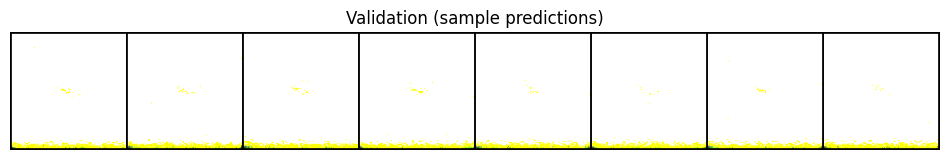

Val[giant white arum lily] @ 3000: pixL1=0.6651 | clipLoss=0.7803 | total=1.4454


NCA[giant white arum lily]: 100%|██████████| 3200/3200 [13:09<00:00,  3.09it/s, clip=nan, loss=nan, pix=nan, steps=48]

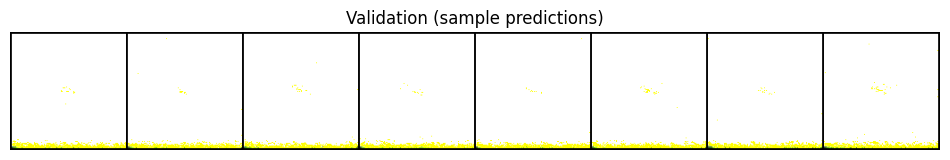

NCA[giant white arum lily]: 100%|██████████| 3200/3200 [13:09<00:00,  4.05it/s, clip=nan, loss=nan, pix=nan, steps=48]


Val[giant white arum lily] @ 3200: pixL1=0.6653 | clipLoss=0.7812 | total=1.4466
Done: giant white arum lily. Latest=latest_flower-giant_white_arum_lily_20250929-092714.pt | Best=best_flower-giant_white_arum_lily_20250929-092714.pt | Final=final_flower-giant_white_arum_lily_20250929-092714.pt


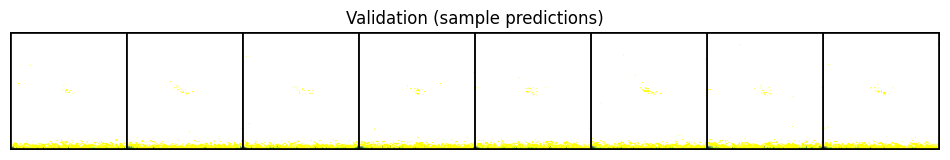

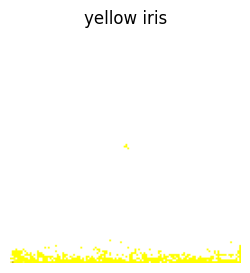

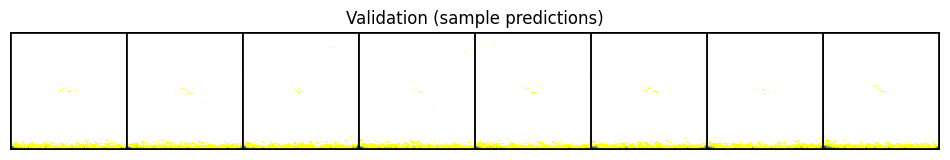

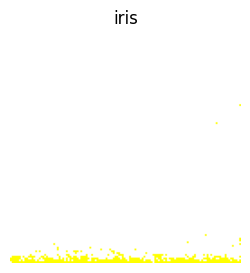

In [5]:
# ================================
# Cell 4 — Per‑Class Experts: Auto‑loop over class_names (eager, GPU‑optimised)
# ================================
import os, time
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -------- FORCE EAGER (disable torch.compile everywhere)
import torch._dynamo
os.environ["TORCH_COMPILE_DISABLE"] = "1"
torch._dynamo.config.suppress_errors = True

def _no_compile(mod, *args, **kwargs):
    return mod
try:
    torch.compile = _no_compile  # make any stray calls a no-op
except Exception:
    pass
print("⚙️ Running in eager mode (torch.compile disabled).")

# -------- Speed flags
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# -------- Sanity: require earlier cells
assert 'nca' in globals(), "Missing 'nca' model (run Cell 3 to define FiLMNCA and instantiate nca)"
assert hasattr(nca, 'parameters'), "'nca' is not an nn.Module instance"
assert 'cond_head' in globals(), "Missing 'cond_head' (run Cell 2 to create TextConditioningHead and cond_head)"
assert hasattr(cond_head, 'parameters'), "'cond_head' is not an nn.Module instance"
assert 'clip_model' in globals(), "Missing 'clip_model' (from Cell 1)"
assert 'device' in globals(), "Missing 'device' variable (set in Cell 1)"
assert 'IMG_SIZE' in globals() and 'STATE_CH' in globals() and 'UPDATE_RATE' in globals(), "Missing IMG_SIZE/STATE_CH/UPDATE_RATE (from Cell 3)"
assert 'train_ds' in globals() and 'val_ds' in globals() and 'class_names' in globals(), "Missing datasets/class_names (from Cell 1)"

# -------- Size sync (avoid 96 vs 128 mismatch)
# Flowers102 transforms use 128x128; run NCA at the same resolution
IMG_SIZE = 128

# -------- Config
BATCH_SIZE      = 16
NUM_WORKERS     = 0   # SAFE (no pickling); after it works, try 2–4 on Linux
PIN_MEMORY      = (device == "cuda")
LR              = 3e-4
WEIGHT_DECAY    = 1e-4
STEPS_SCHEDULE  = [16, 24, 32, 40, 48]
PIX_W, CLIP_W   = 0.7, 0.3
MAX_ITERS       = 3200   # per-class: shorter runs; change as needed
LOG_VALID_EVERY = 200
SAVE_EVERY      = 200

# Which classes to train as experts — by default, ALL
# For quick smoke tests, set a small subset, e.g.:
CLASSES_TO_TRAIN = ["yellow iris", "giant white arum lily"]
# CLASSES_TO_TRAIN = list(class_names)

from torch.cuda.amp import autocast, GradScaler


def current_steps(it: int) -> int:
    if not STEPS_SCHEDULE:
        return 32
    prog = max(0.0, min(1.0, it / MAX_ITERS))
    idx = min(int(prog * len(STEPS_SCHEDULE)), len(STEPS_SCHEDULE) - 1)
    return STEPS_SCHEDULE[idx]

# -------- Dataset wrapper (picklable: no model handles stored)
class FlowersWithText(torch.utils.data.Dataset):
    def __init__(self, base_ds, class_names):
        self.base = base_ds
        self.class_names = class_names
        # Precompute CLIP text embeddings for class names (CPU tensors)
        print("Precomputing text embeddings for all classes (CPU)…")
        self.class_embeds = {}
        for cname in class_names:
            with torch.no_grad():
                emb = prompt_to_embedding(cname)  # returns [512] CPU from Cell 1
            self.class_embeds[cname] = emb

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        cname = self.class_names[label]
        text_emb = self.class_embeds[cname]  # [512] CPU
        return {"image": img, "label": label, "class_name": cname, "text_embed": text_emb}

# Build wrapped datasets ONCE (no loaders yet)
train_all = FlowersWithText(train_ds, class_names)
val_all   = FlowersWithText(val_ds,   class_names)

# helper to build per-class loaders
from torch.utils.data import Subset

def _class_indices(ds, cname):
    # Flowers102 stores labels on ._labels; fall back to attribute on sample
    labels = getattr(ds, "_labels", None)
    if labels is None:
        # slow path: query by indexing
        out = []
        for i in range(len(ds)):
            _, y = ds[i]
            if class_names[y] == cname:
                out.append(i)
        return out
    return [i for i, y in enumerate(labels) if class_names[y] == cname]


def build_loaders_for_class(cname):
    tr_idx = _class_indices(train_ds, cname)
    va_idx = _class_indices(val_ds,   cname)
    assert len(tr_idx) > 0 and len(va_idx) > 0, f"No samples for class '{cname}'"
    # Use per-class batch sizes so very small classes still yield batches
    bs_tr = max(1, min(BATCH_SIZE, len(tr_idx)))
    bs_va = max(1, min(BATCH_SIZE, len(va_idx)))
    tr = Subset(train_all, tr_idx)
    va = Subset(val_all,   va_idx)
    tl = DataLoader(
        tr,
        batch_size=bs_tr,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        drop_last=False,              # don't drop for tiny classes
        persistent_workers=False,
    )
    vl = DataLoader(
        va,
        batch_size=bs_va,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        drop_last=False,             # keep every batch
        persistent_workers=False,
    )
    return tl, vl

# -------- GPU-native CLIP image encoding (no PIL)
import torch.nn.functional as _F
_CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device)[:, None, None]
_CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device)[:, None, None]


def clip_encode_images_gpu(imgs_0_1: torch.Tensor) -> torch.Tensor:
    x = _F.interpolate(imgs_0_1, size=(224, 224), mode="bicubic", align_corners=False)
    x = (x - _CLIP_MEAN) / _CLIP_STD
    with torch.no_grad():
        zi = clip_model.encode_image(x)
    return _F.normalize(zi, dim=-1)

# Freeze CLIP
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad_(False)

# ---- dtype helper for projection head to avoid Half/Float matmul

def _head_dtype():
    return next(cond_head.parameters()).dtype

# -------- Optimiser / AMP (created per-class later)
optim = None
scaler = None

# -------- Checkpointing
CKPT_DIR   = Path("./checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
RUN_TAG    = time.strftime("%Y%m%d-%H%M%S")
CKPT_LATEST = CKPT_DIR / f"latest_{RUN_TAG}.pt"
CKPT_BEST   = CKPT_DIR / f"best_{RUN_TAG}.pt"
CKPT_FINAL  = CKPT_DIR / f"final_{RUN_TAG}.pt"


def save_ckpt(path, it, best_score=None, extra=None):
    torch.save({
        "iter": it,
        "nca": nca.state_dict(),
        "cond_head": cond_head.state_dict(),
        "optim": optim.state_dict(),
        "scaler": scaler.state_dict(),
        "best_score": (None if best_score is None else float(best_score)),
        "extra": extra or {}
    }, path)

# -------- Seed helper

def make_seed(B, H=IMG_SIZE, W=IMG_SIZE, C=STATE_CH):
    x = torch.zeros(B, C, H, W, device=device)
    cy, cx = H // 2, W // 2
    x[:, 3:, cy-1:cy+1, cx-1:cx+1] = 1.0
    return x

# -------- Train step

def train_step(batch, it):
    imgs    = batch["image"].to(device, non_blocking=True)      # [B,3,H,W]
    text512 = batch["text_embed"].to(device, non_blocking=True) # [B,512]

    steps = current_steps(it)
    seed  = make_seed(imgs.size(0))
    nca.train()

    # 1) normalise text on GPU under autocast
    with autocast(enabled=(device == "cuda")):
        cond_in = F.normalize(text512, dim=-1)

    # 2) run projection head in fp32 to avoid Half/Float mismatch
    with autocast(enabled=False):
        cond = cond_head(cond_in.to(_head_dtype()).float())      # [B,128] fp32

    # 3) run NCA under autocast again
    with autocast(enabled=(device == "cuda")):
        out  = nca(seed, cond, steps=steps, update_rate=UPDATE_RATE)
        rgb  = out[:, :3]
        target = imgs
        pixel = F.l1_loss(rgb, target)
        zi = clip_encode_images_gpu(rgb)
        zt = F.normalize(text512, dim=-1)
        clip_loss = 1.0 - (zi * zt).sum(dim=1).mean()
        loss = PIX_W * pixel + CLIP_W * clip_loss

    optim.zero_grad(set_to_none=True)
    scaler.scale(loss).backward()
    torch.nn.utils.clip_grad_norm_(nca.parameters(), 1.0)
    scaler.step(optim); scaler.update()
    return float(loss.detach()), float(pixel.detach()), float(clip_loss.detach())

# -------- Validation
@torch.no_grad()
def validate(max_batches=8, rollout_steps=None, show_grid=True):
    nca.eval()
    tot_pix, tot_clip, tot = 0.0, 0.0, 0
    grid_img = None
    iters = 0
    for batch in val_loader:
        imgs    = batch["image"].to(device, non_blocking=True)
        text512 = batch["text_embed"].to(device, non_blocking=True)
        # run projection head in fp32 during validation as well
        with autocast(enabled=False):
            cond = cond_head(F.normalize(text512, dim=-1).float())
        steps   = rollout_steps if rollout_steps is not None else current_steps(0)
        seed    = make_seed(imgs.size(0))
        out     = nca(seed, cond, steps=steps, update_rate=UPDATE_RATE)
        rgb     = out[:, :3].clamp(0,1)

        pixel = F.l1_loss(rgb, imgs).item()
        zi    = clip_encode_images_gpu(rgb)
        zt    = F.normalize(text512, dim=-1)
        clip_loss = (1.0 - (zi * zt).sum(dim=1)).mean().item()

        bs = imgs.size(0)
        tot_pix  += pixel * bs
        tot_clip += clip_loss * bs
        tot      += bs
        iters    += 1

        if show_grid and grid_img is None:
            grid_img = make_grid(rgb[:8].detach().cpu(), nrow=8, padding=2)

        if iters >= max_batches:
            break

    if grid_img is not None and show_grid:
        plt.figure(figsize=(12,3)); plt.axis("off")
        plt.imshow(grid_img.permute(1,2,0).numpy())
        plt.title("Validation (sample predictions)")
        plt.show()

    return {"val_pixL1": tot_pix / max(1, tot),
            "val_clipLoss": tot_clip / max(1, tot)}

# -------- Utility: (re)init models & optim for each class
import copy
INIT_NCA_STATE  = copy.deepcopy(nca.state_dict())
INIT_HEAD_STATE = copy.deepcopy(cond_head.state_dict())

def reset_models_and_optim():
    global optim, scaler
    nca.load_state_dict(INIT_NCA_STATE)
    cond_head.load_state_dict(INIT_HEAD_STATE)
    optim = torch.optim.AdamW(list(nca.parameters()) + list(cond_head.parameters()),
                              lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = GradScaler(enabled=(device == "cuda"))

# -------- Per-class training loop
for TARGET_CLASS in CLASSES_TO_TRAIN:
    print(f"===== Training expert for class: {TARGET_CLASS} =====")
    train_loader, val_loader = build_loaders_for_class(TARGET_CLASS)
    reset_models_and_optim()

    # per-class checkpoint paths
    CKPT_DIR   = Path("./checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
    RUN_TAG    = time.strftime("%Y%m%d-%H%M%S")
    TAG        = f"flower-{TARGET_CLASS.replace(' ','_')}"
    CKPT_LATEST = CKPT_DIR / f"latest_{TAG}_{RUN_TAG}.pt"
    CKPT_BEST   = CKPT_DIR / f"best_{TAG}_{RUN_TAG}.pt"
    CKPT_FINAL  = CKPT_DIR / f"final_{TAG}_{RUN_TAG}.pt"

    it = 0
    best_score = float("inf")
    pbar = tqdm(total=MAX_ITERS, desc=f"NCA[{TARGET_CLASS}]", dynamic_ncols=True)

    try:
        train_iter = iter(train_loader)
        while it < MAX_ITERS:
            try:
                batch = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader); batch = next(train_iter)

            it += 1
            L, Lp, Lc = train_step(batch, it)
            if it % 50 == 0 or it == 1:
                pbar.set_postfix(loss=f"{L:.4f}", pix=f"{Lp:.4f}", clip=f"{Lc:.4f}", steps=current_steps(it))
            pbar.update(1)

            if it % SAVE_EVERY == 0:
                save_ckpt(CKPT_LATEST, it)

            if it % LOG_VALID_EVERY == 0:
                scores = validate(max_batches=8, rollout_steps=current_steps(it), show_grid=True)
                score_scalar = scores["val_pixL1"] + scores["val_clipLoss"]
                print(f"Val[{TARGET_CLASS}] @ {it}: pixL1={scores['val_pixL1']:.4f} | clipLoss={scores['val_clipLoss']:.4f} | total={score_scalar:.4f}")
                if score_scalar < best_score:
                    best_score = score_scalar
                    save_ckpt(CKPT_BEST, it, best_score, extra={"class": TARGET_CLASS, **scores})
                    print(f"✅ Saved BEST → {CKPT_BEST.name}")

        save_ckpt(CKPT_FINAL, it, best_score, extra={"class": TARGET_CLASS})
        pbar.close()
        print(f"Done: {TARGET_CLASS}. Latest={CKPT_LATEST.name} | Best={CKPT_BEST.name} | Final={CKPT_FINAL.name}")
    except KeyboardInterrupt:
        pbar.close()
        save_ckpt(CKPT_LATEST, it)
        print(f"Interrupted {TARGET_CLASS} @ iter {it}. Latest ckpt at {CKPT_LATEST.name}")

# -------- Prompt inference helper (use the last trained expert by default)
@torch.no_grad()
def prompt_generate(prompts=None, steps=48):
    nca.eval()
    prompts = prompts or [CLASSES_TO_TRAIN[-1], f"pink {CLASSES_TO_TRAIN[-1]}"]
    cond = torch.stack([prompt_to_cond(p) for p in prompts], dim=0).to(device)
    seed = torch.zeros(len(prompts), STATE_CH, IMG_SIZE, IMG_SIZE, device=device)
    cy, cx = IMG_SIZE//2, IMG_SIZE//2
    seed[:, 3:, cy-1:cy+1, cx-1:cx+1] = 1.0
    out = nca(seed, cond, steps=steps, update_rate=UPDATE_RATE)
    rgb = out[:, :3].clamp(0,1).cpu()
    grid = make_grid(rgb, nrow=len(prompts), padding=2)
    plt.figure(figsize=(3*len(prompts), 3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0).numpy()); plt.title(" | ".join(prompts)); plt.show()
    return rgb

# Quick demo after loop (optional):
try:
    user_in = input(f"Enter prompts for '{CLASSES_TO_TRAIN[-1]}' separated by ' | ': ").strip()
    prompts = [p.strip() for p in user_in.split("|")] if user_in else [CLASSES_TO_TRAIN[-1], f"pink {CLASSES_TO_TRAIN[-1]}"]
except Exception:
    prompts = [CLASSES_TO_TRAIN[-1], f"pink {CLASSES_TO_TRAIN[-1]}"]

_ = validate(max_batches=4, rollout_steps=48, show_grid=True)
_ = prompt_generate(prompts, steps=48)

@torch.no_grad()
def prompt_generate(prompts, steps=48):
    nca.eval()
    cond = torch.stack([prompt_to_cond(p) for p in prompts], dim=0).to(device)
    seed = torch.zeros(len(prompts), STATE_CH, IMG_SIZE, IMG_SIZE, device=device)
    cy, cx = IMG_SIZE//2, IMG_SIZE//2
    seed[:, 3:, cy-1:cy+1, cx-1:cx+1] = 1.0
    out = nca(seed, cond, steps=steps, update_rate=UPDATE_RATE)
    rgb = out[:, :3].clamp(0,1).cpu()
    grid = make_grid(rgb, nrow=len(prompts), padding=2)
    plt.figure(figsize=(3*len(prompts), 3)); plt.axis("off")
    plt.imshow(grid.permute(1,2,0).numpy()); plt.title(" | ".join(prompts)); plt.show()
    return rgb

try:
    user_in = input("\nEnter prompt(s) separated by ' | ' (e.g., pink sunflower | white rose): ").strip()
    prompts = [p.strip() for p in user_in.split("|")] if user_in else ["sunflower", "pink sunflower", "white rose"]
except Exception:
    prompts = ["sunflower", "pink sunflower", "white rose"]

_ = validate(max_batches=6, rollout_steps=48, show_grid=True)  # quick sanity
_ = prompt_generate(prompts, steps=48)


Loading pipeline components...: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Loading pipeline components...: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abid

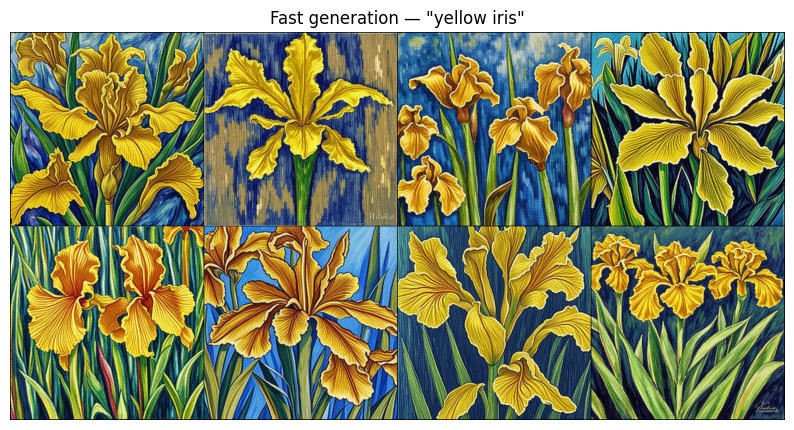

In [2]:
import sys, subprocess
import torch
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchvision.utils import make_grid

# Try to import diffusers; install if missing
try:
    from diffusers import AutoPipelineForText2Image
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "diffusers", "transformers", "accelerate", "safetensors"]) 
    from diffusers import AutoPipelineForText2Image

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prompt / generation settings
prompt = "yellow iris"
num_images = 8
height = 512
width = 512
steps = 4          # sd-turbo works well in 1–4 steps
guidance = 0.0     # sd-turbo is trained for zero CFG

# On CPU, use smaller size for speed
if device == "cpu":
    height = min(height, 384)
    width = min(width, 384)

# Build pipeline (sd-turbo is extremely fast)
dtype = torch.float16 if device == "cuda" else torch.float32
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sd-turbo",
    torch_dtype=dtype,
)
pipe = pipe.to(device)

# Optional speed tweaks
if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
    except Exception:
        pass
else:
    try:
        pipe.enable_attention_slicing()
    except Exception:
        pass

pipe.set_progress_bar_config(disable=True)

# Generate
generator = torch.Generator(device=device).manual_seed(42)
prompts = [prompt] * num_images
with torch.inference_mode():
    out = pipe(prompts, num_inference_steps=steps, guidance_scale=guidance,
               generator=generator, height=height, width=width)
images = out.images  # list of PIL images

# Convert to tensor grid for display
to_tensor = T.ToTensor()
imgs_t = torch.stack([to_tensor(img) for img in images], dim=0)  # [N,3,H,W]
grid = make_grid(imgs_t, nrow=4, padding=2)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title(f'Fast generation — "{prompt}"')
plt.show()